In [1]:
import sys
sys.path.append('../')
import src.utils as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
reload(utils)
import scipy.stats as stat

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings("ignore")

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')

In [3]:
default_params = {
'K' : 100,
'mu': 0.01,
't' : 0,
'T' : 1,
'r' : 0.03,
'S' : 100,
'sigma' : 0.1
}

K = default_params['K']
S0 = default_params['S']
t = default_params['t']
T = default_params['T']
r = default_params['r']
sigma = default_params['sigma']
mu = default_params['mu']

In [4]:
nsims = 10_000
Nt = 1_000

GBM = utils.GeometricBrownianMotion(x0=S0, mu=mu, sigma = sigma, T= T, Nt = Nt)
timesteps = GBM.timesteps.copy()

S_paths = GBM.simulate(nsims)
B_paths = np.repeat(np.exp(r*timesteps).reshape(-1,1), nsims, axis = 1)

number_of_shares_paths = np.zeros((Nt, nsims))  # \Delta_t
money_market_account_paths = np.zeros((Nt, nsims)) # \gamma_t

## Derivative to replicate: European call option $K=100$

In [5]:
K = 100.
payoff = np.maximum(S_paths[-1,:] - K, 0.)

price = utils.computeBlackScholesCallPrice(t, T, S0, r, sigma, K)

# First time step
Delta = utils.computeDeltaCall(t=t,T=T,S=S_paths[0,:],r=r,sigma=sigma,K=K)

number_of_shares_paths[0,:] = Delta
aux_money_needed = Delta * S_paths[0,:]
money_market_account_paths[0,:] = - aux_money_needed/B_paths[0,:] + price/ B_paths[0,:]


for it, t in enumerate(timesteps[1:-1]):
    i = it + 1
    Delta = utils.computeDeltaCall(t=t,T=T,S=S_paths[i,:],r=r,sigma=sigma,K=K)
    number_of_shares_paths[i,:] = Delta
    aux_money_needed = (Delta - number_of_shares_paths[i-1,:]) * S_paths[i,:]
    money_market_account_paths[i,:] = money_market_account_paths[i-1,:]  - aux_money_needed/B_paths[i,:]

In [6]:
replicated_payoff = number_of_shares_paths[-1,:] * S_paths[-1, :] + money_market_account_paths[-1,:] * B_paths[-1,:]

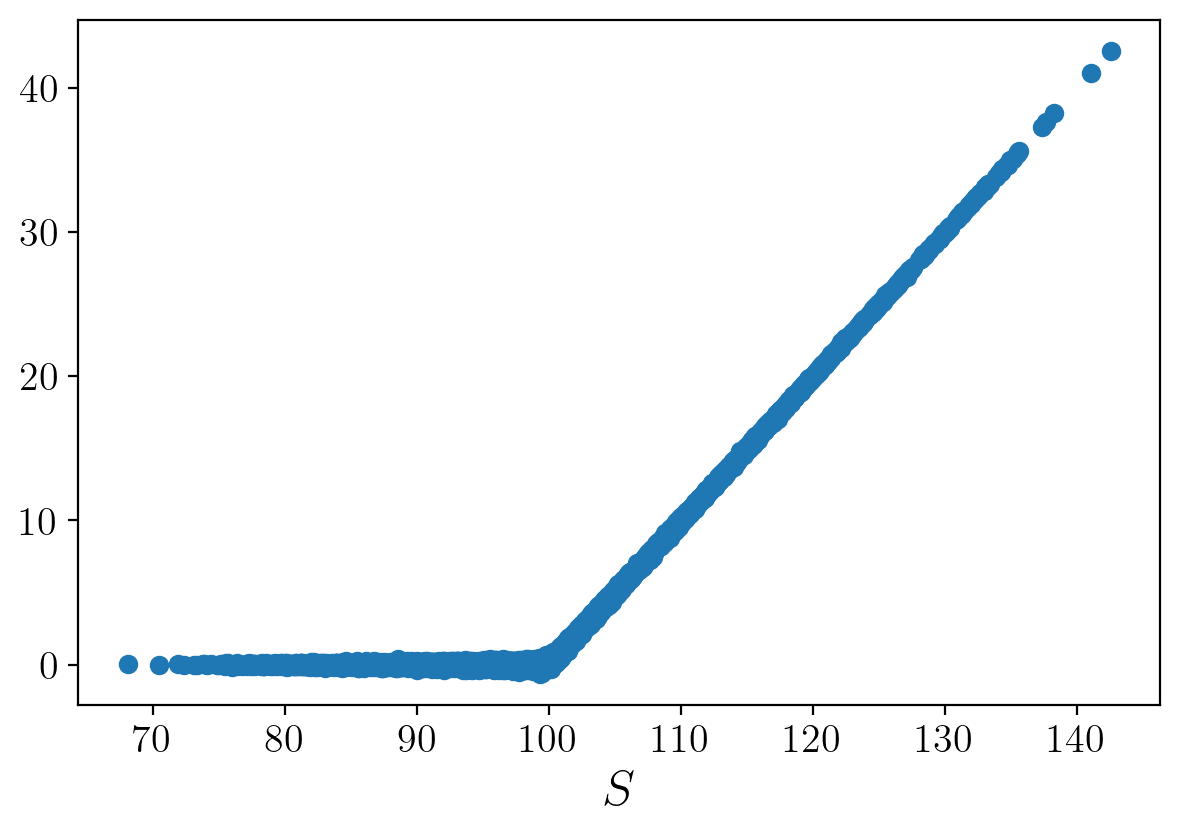

In [8]:
plt.figure()
plt.scatter(S_paths[-1,:], replicated_payoff)
resolution_value = 50
plt.tight_layout()
plt.xlabel(r'$S$',  fontsize=18)
plt.show()

## Let us wrap all of the above into a function that does it all

In [9]:
def replicate_payoff(nsims, Nt, params, verbose = False):
    K = params['K']
    S0 = params['S']
    t = params['t']
    T = params['T']
    r = params['r']
    sigma = params['sigma']
    mu = params['mu'] 
    
    GBM = utils.GeometricBrownianMotion(x0=S0, mu=mu, sigma = sigma, T= T, Nt = Nt)
    timesteps = GBM.timesteps.copy()

    S_paths = GBM.simulate(nsims)
    B_paths = np.repeat(np.exp(r*timesteps).reshape(-1,1), nsims, axis = 1)

    number_of_shares_paths = np.zeros((Nt, nsims))  # \Delta_t
    money_market_account_paths = np.zeros((Nt, nsims)) # \gamma_t
    
    payoff = np.maximum(S_paths[-1,:] - K, 0.)

    price = utils.computeBlackScholesCallPrice(t, T, S0, r, sigma, K)

    # First time step
    Delta = utils.computeDeltaCall(t=t,T=T,S=S_paths[0,:],r=r,sigma=sigma,K=K)

    number_of_shares_paths[0,:] = Delta
    aux_money_needed = Delta * S_paths[0,:]
    money_market_account_paths[0,:] = - aux_money_needed/B_paths[0,:] + price/ B_paths[0,:]


    for it, t in enumerate(timesteps[1:-1]):
        i = it + 1
        Delta = utils.computeDeltaCall(t=t,T=T,S=S_paths[i,:],r=r,sigma=sigma,K=K)
        number_of_shares_paths[i,:] = Delta
        aux_money_needed = (Delta - number_of_shares_paths[i-1,:]) * S_paths[i,:]
        money_market_account_paths[i,:] = money_market_account_paths[i-1,:]  - aux_money_needed/B_paths[i,:]
        
    replicated_payoff = number_of_shares_paths[-1,:] * S_paths[-1, :] + money_market_account_paths[-1,:] * B_paths[-1,:]
        
    if verbose:
        return replicated_payoff, number_of_shares_paths, money_market_account_paths, S_paths, B_paths
    else:
        return replicated_payoff, S_paths

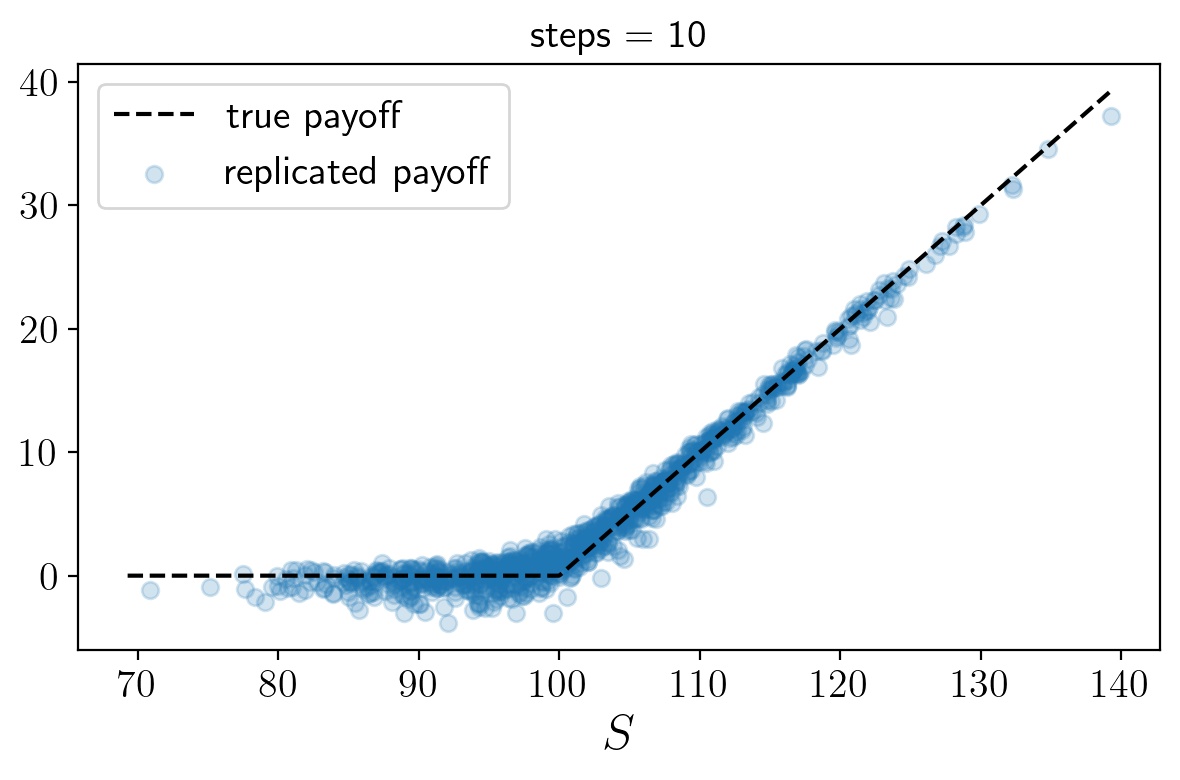

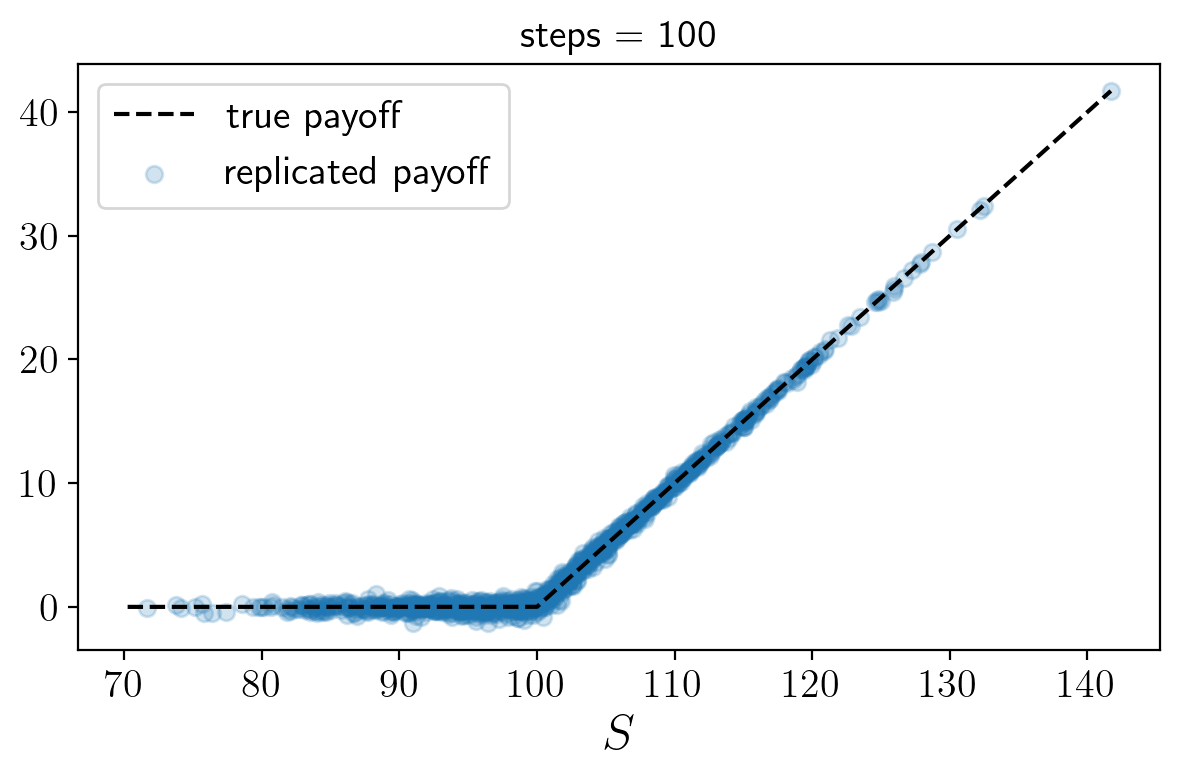

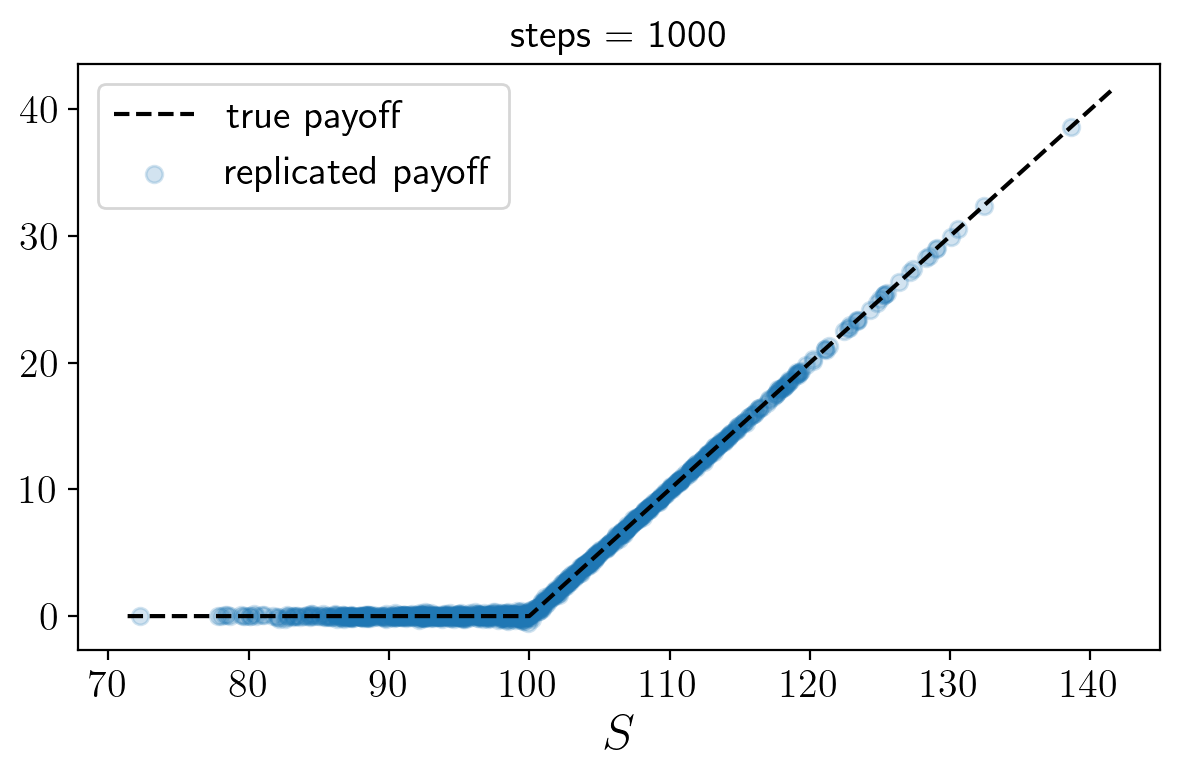

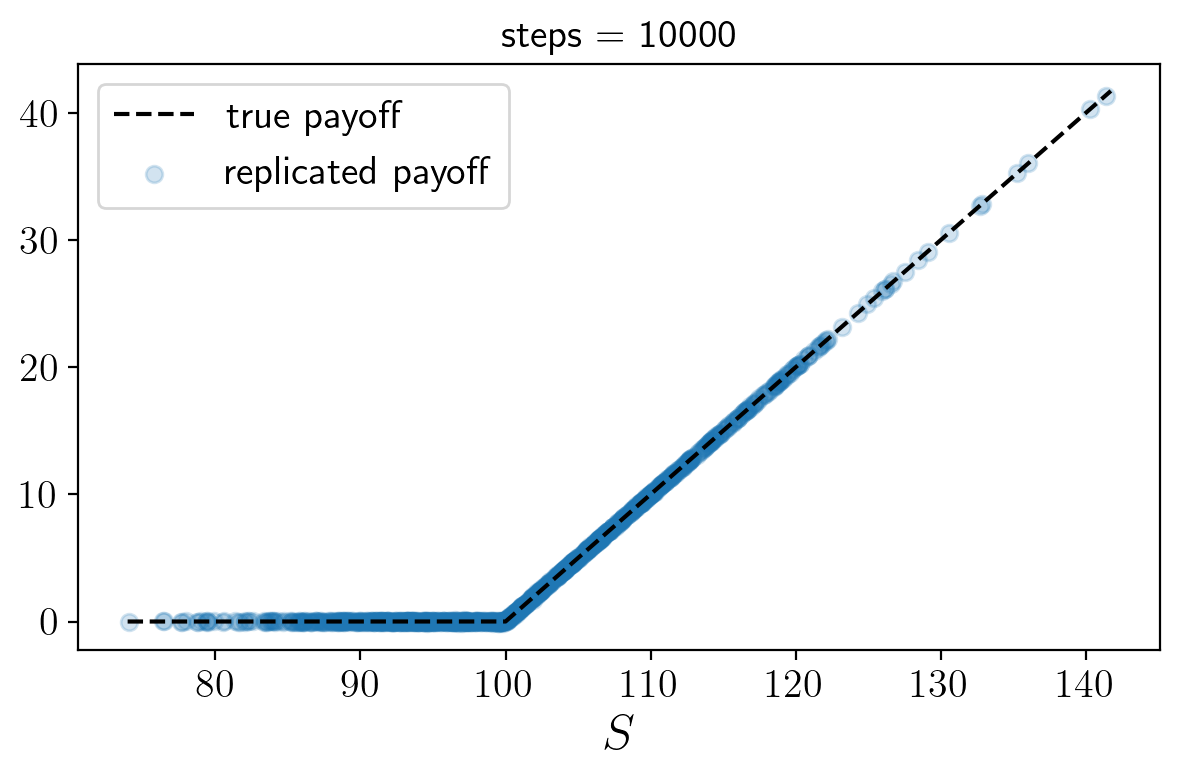

In [10]:
nsims = 1000
for Nt in [10, 100, 1_000, 10_000]:
    replicated_payoff, S_paths = replicate_payoff(nsims=nsims, Nt=Nt, params = default_params)

    S_grid = np.linspace(np.min(S_paths), np.max(S_paths), 1000)
    payoff = utils.call_option_payoff(K = K, S = S_grid)

    plt.figure()
    plt.plot(S_grid, payoff, linestyle = '--', color='black', label = 'true payoff')
    plt.scatter(S_paths[-1,:], replicated_payoff, alpha=0.2, label = 'replicated payoff')
    resolution_value = 50
    plt.legend()
    plt.title(f'steps = {Nt}')
    plt.xlabel(r'$S$',  fontsize=18)
    plt.tight_layout()
    plt.savefig(f'../figures/call-replication-vs-payoff-{Nt}steps.pdf', format="pdf", dpi=resolution_value)
    plt.show()

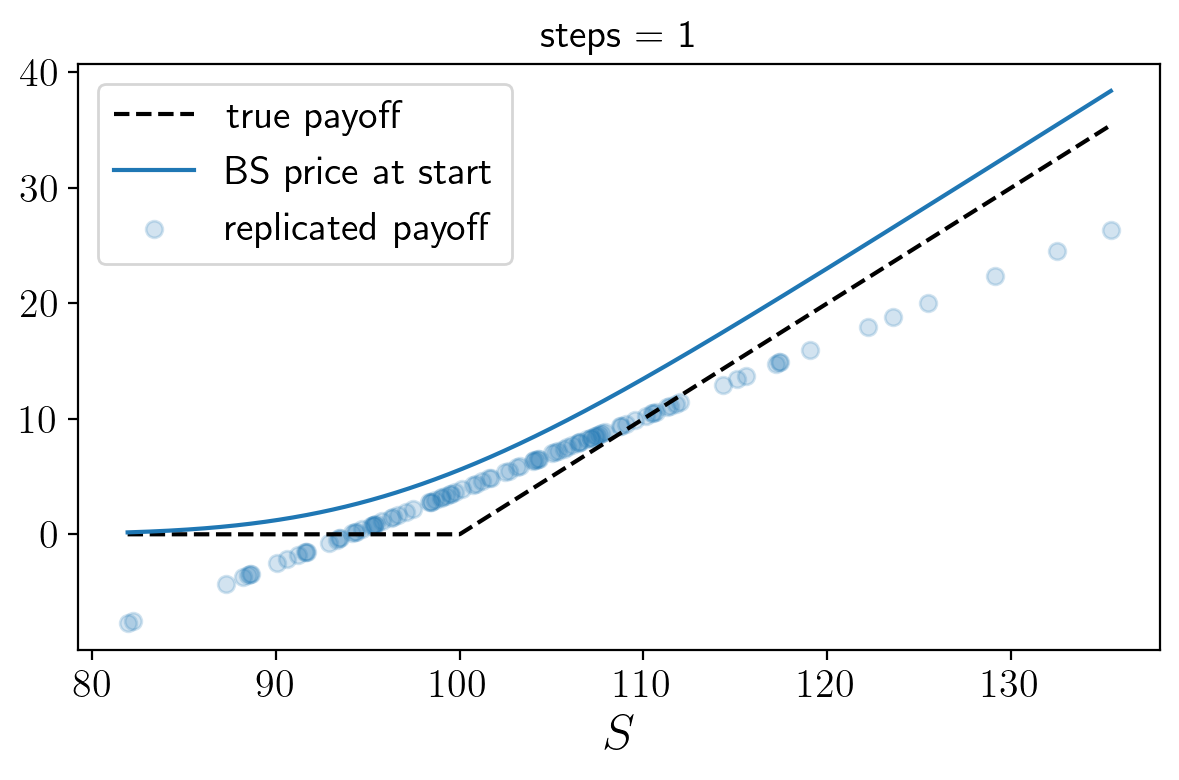

In [11]:
nsims = 100
Nt = 1
replicated_payoff, number_of_shares_paths, money_market_account_paths, S_paths, B_paths = replicate_payoff(nsims=nsims, Nt=Nt, params = default_params, verbose=True)

S_grid = np.linspace(np.min(S_paths), np.max(S_paths), 1000)
payoff = utils.call_option_payoff(K = K, S = S_grid)
prices = utils.computeBlackScholesCallPrice(0., T, S_grid, r, sigma, K)

plt.figure()
plt.plot(S_grid, payoff, linestyle = '--', color='black', label = 'true payoff')
plt.plot(S_grid, prices, linestyle = '-', color='tab:blue', label = 'BS price at start')

plt.scatter(S_paths[-1,:], replicated_payoff, alpha=0.2, label = 'replicated payoff')
resolution_value = 50
plt.legend()
plt.title(f'steps = {Nt}')
plt.xlabel(r'$S$',  fontsize=18)
plt.tight_layout()
plt.show()